### Content-based recommendation system

1. Import potrzebnych bibliotek

In [136]:
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine, text
import sklearn.feature_extraction.text as sk_text
import sklearn.metrics.pairwise as sk_pairwise

2. Wczytanie danych

In [137]:
# Connect to PostgreSQL server
host= "localhost"
database="movierecommenderdb"
user= "postgres"
password= "postgres"
port= "5432"


alchemyEngine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')
 
# Connect to PostgreSQL server
dbConnection = alchemyEngine.connect()

# Read data from PostgreSQL database table and load into a DataFrame instance
query_movies = text('SELECT * FROM "Movies"')
query_credits = text('SELECT * FROM "Credits"')
query_keywords = text('SELECT * FROM "Keywords"')
df_movie = pd.read_sql_query(query_movies, dbConnection)
df_credits = pd.read_sql_query(query_credits, dbConnection)
df_keywords = pd.read_sql_query(query_keywords, dbConnection)

pd.set_option('display.expand_frame_repr', False)

# Close the database connection
dbConnection.close()

3. Przygotowanie i czyszczenie danych

In [138]:
#merge df_movie, df_credits, df_keywords
df_movie = df_movie.merge(df_credits, on='movieId')
df_movie = df_movie.merge(df_keywords, on='movieId')
df_movies_explore = df_movie.copy()

In [139]:
#let only the columns we need
df_movie = df_movie[['movieId','title','overview','genres','keywords','cast','director']]
df_movie.head()

,movieId,title,overview,genres,keywords,cast,director
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","['Animation', 'Comedy', 'Family']","['jealousy', 'toy', 'boy', 'friendship', 'frie...","['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...",['John Lasseter']
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,"['Adventure', 'Fantasy', 'Family']","['board game', 'disappearance', ""based on chil...","['Robin Williams', 'Jonathan Hyde', 'Kirsten D...",['Joe Johnston']
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,"['Romance', 'Comedy']","['fishing', 'best friend', 'duringcreditssting...","['Walter Matthau', 'Jack Lemmon', 'Ann-Margret...",['Howard Deutch']
3,31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","['Comedy', 'Drama', 'Romance']","['based on novel', 'interracial relationship',...","['Whitney Houston', 'Angela Bassett', 'Loretta...",['Forest Whitaker']
4,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,['Comedy'],"['baby', 'midlife crisis', 'confidence', 'agin...","['Steve Martin', 'Diane Keaton', 'Martin Short...",['Charles Shyer']


In [140]:
#convert all strings to lowercase and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace("',",", ").replace("'","").replace("[","").replace("]","").replace('"','').replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace("',",", ").replace("'","").replace("[","").replace("]","").replace('"','').replace(" ", ""))
        else:
            return ''

features = ['cast', 'director', 'keywords', 'genres']

#apply clean_data to features
for feature in features:
    df_movie[feature] = df_movie[feature].map(lambda x: x.split(','))
    df_movie[feature] = df_movie[feature].apply(clean_data)

df_movie.head()

,movieId,title,overview,genres,keywords,cast,director
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[animation, comedy, family]","[jealousy, toy, boy, friendship, friends, riva...","[tomhanks, timallen, donrickles, jimvarney, wa...",[johnlasseter]
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,"[adventure, fantasy, family]","[boardgame, disappearance, basedonchildrensboo...","[robinwilliams, jonathanhyde, kirstendunst, br...",[joejohnston]
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[romance, comedy]","[fishing, bestfriend, duringcreditsstinger, ol...","[waltermatthau, jacklemmon, ann-margret, sophi...",[howarddeutch]
3,31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[comedy, drama, romance]","[basedonnovel, interracialrelationship, single...","[whitneyhouston, angelabassett, lorettadevine,...",[forestwhitaker]
4,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,[comedy],"[baby, midlifecrisis, confidence, aging, daugh...","[stevemartin, dianekeaton, martinshort, kimber...",[charlesshyer]


In [141]:
#combine all features into one column
def create_combined_column(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + ' '.join(x['director']) + ' ' + ' '.join(x['genres'])

df_movie['combined'] = df_movie.apply(create_combined_column, axis=1)

#take only the columns we need
df_movie = df_movie[['movieId','title','combined']]

df_movie.head()

,movieId,title,combined
0,862,Toy Story,jealousy toy boy friendship friends rivalry bo...
1,8844,Jumanji,boardgame disappearance basedonchildrensbook n...
2,15602,Grumpier Old Men,fishing bestfriend duringcreditsstinger oldmen...
3,31357,Waiting to Exhale,basedonnovel interracialrelationship singlemot...
4,11862,Father of the Bride Part II,baby midlifecrisis confidence aging daughter m...


In [142]:
df_movie.shape

(42276, 3)

In [143]:
df_movie['combined'][1]

'boardgame disappearance basedonchildrensbook newhome recluse giantinsect robinwilliams jonathanhyde kirstendunst bradleypierce bonniehunt bebeneuwirth davidalangrier patriciaclarkson adamhann-byrd laurabellbundy jameshandy gillianbarber brandonobray cyrusthiedeke garyjosephthorup leonardzola lloydberry malcolmstewart annabelkershaw darrylhenriques robyndriscoll peterbryant sarahgilson floricavlad junelion brendalockmuller joejohnston adventure fantasy family'

4. EDA

In [144]:
#exploratory data analysis
df_movies_explore.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'movieId', 'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'IMBD_poster_path', 'IMBD_backdrop_path',
       'cast', 'director', 'keywords'],
      dtype='object')

Text(0.5, 1.0, 'Most popular movies')

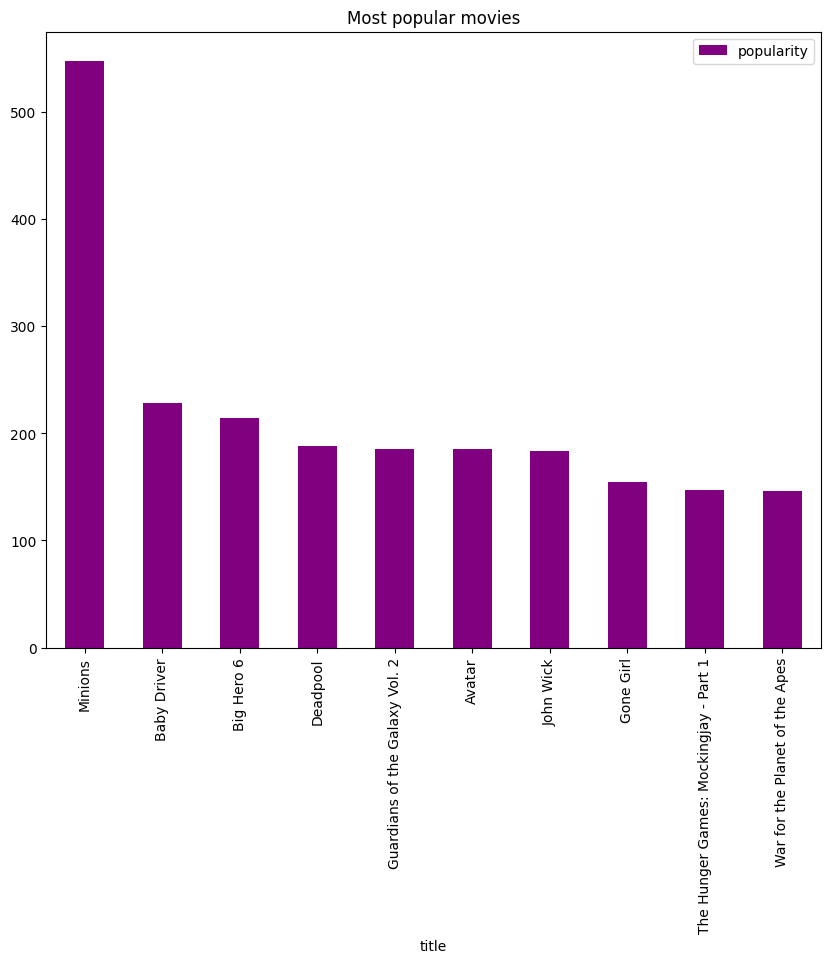

In [145]:
import matplotlib.pyplot as plt

#plot most popular movies
df_movies_explore['popularity'].describe()

#change popularity to float
df_movies_explore['popularity'] = pd.to_numeric(df_movies_explore['popularity'], errors='coerce')

most_popular_movies = df_movies_explore.sort_values(by='popularity', ascending=False)[['title','popularity']].head(10)
most_popular_movies.plot(kind='bar', x='title', y='popularity',color = 'purple', figsize=(10,8))
plt.title('Most popular movies')

Text(0.5, 1.0, 'Most rated movies')

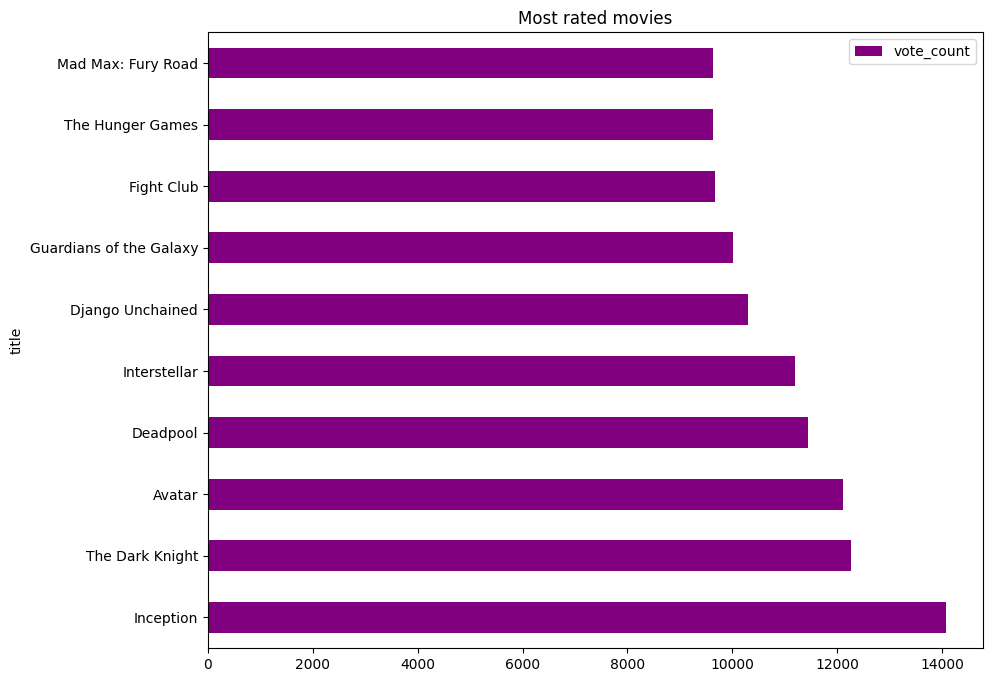

In [146]:
#mark empty values as null
df_movies_explore['vote_average'] = pd.to_numeric(df_movies_explore['vote_average'], errors='coerce')
df_movies_explore['vote_count'] = pd.to_numeric(df_movies_explore['vote_count'], errors='coerce')

#plot most rated movies
most_rated_movies = df_movies_explore.sort_values(by='vote_count', ascending=False)[['title','vote_count']].head(10)
most_rated_movies.plot(kind='barh', x='title', y='vote_count',color = 'purple', figsize=(10,8))
plt.title('Most rated movies')


In [147]:
#most popular directors
df_movies_explore['director'].tolist()
print(df_movies_explore['director'].isnull().sum())

0


Text(0.5, 1.0, 'Most popular directors')

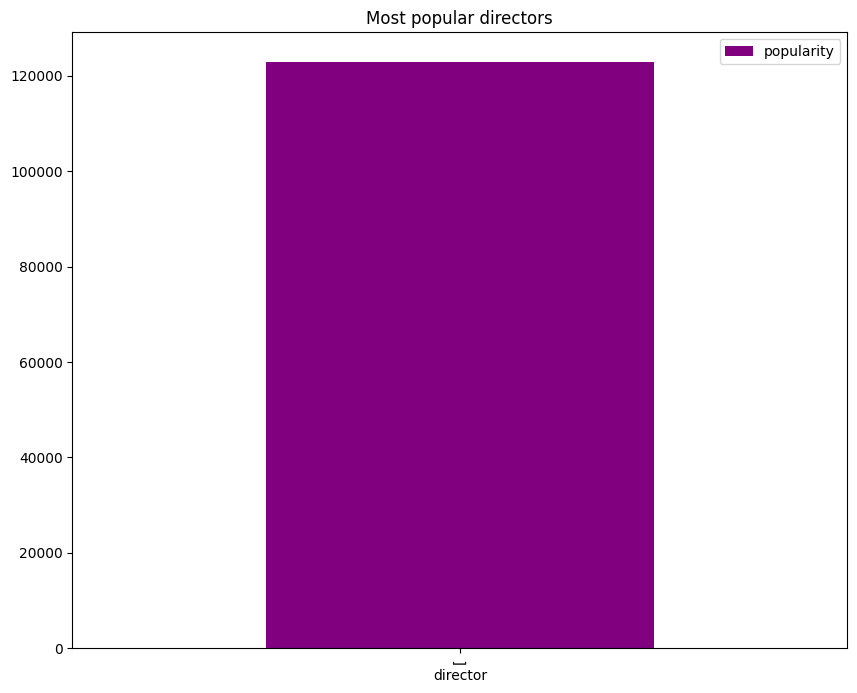

In [148]:

#plot most popular directors
df_movies_explore['director'] = df_movies_explore['director'].apply(lambda x: x[0] if x else "No director found")
most_popular_directors = df_movies_explore.groupby('director')['popularity'].sum().reset_index()
most_popular_directors = most_popular_directors.sort_values(by='popularity', ascending=False).head(10)
most_popular_directors.plot(kind='bar', x='director', y='popularity',color = 'purple', figsize=(10,8))
plt.title('Most popular directors')


5. Ekstrakcja cech

In [149]:
#convert combined column from text to feature vector
vectorizer = sk_text.TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_movie['combined'])

print(X)

  (0, 65712)	0.09065845770248461
  (0, 41521)	0.05412887279318929
  (0, 11876)	0.10082070915165445
  (0, 104583)	0.21432717637754442
  (0, 167572)	0.21174984427542742
  (0, 189185)	0.2511199628837299
  (0, 124249)	0.19541338208245773
  (0, 123588)	0.2062913000134549
  (0, 63170)	0.22870563144859238
  (0, 104878)	0.2456614186217573
  (0, 13339)	0.22047483747894905
  (0, 105354)	0.19137519626536642
  (0, 219273)	0.18007818937046063
  (0, 101231)	0.21055633781243877
  (0, 54916)	0.20183134460891716
  (0, 208752)	0.20266064538539658
  (0, 210508)	0.18181381286926904
  (0, 212466)	0.21432717637754442
  (0, 156790)	0.25815725039038456
  (0, 25626)	0.2511199628837299
  (0, 179866)	0.17578635854572142
  (0, 70848)	0.16027845132426247
  (0, 70849)	0.13946674017822996
  (0, 25587)	0.18368205097276355
  (0, 212461)	0.21055633781243877
  :	:
  (42272, 65712)	0.15822323156556412
  (42273, 151752)	0.2708181473841452
  (42273, 176403)	0.2708181473841452
  (42273, 22343)	0.2708181473841452
  (42273, 1

6. Miara podobieństwa

In [150]:
#finding the similarity scores between movies using cosine similarity
cosine_sim = sk_pairwise.cosine_similarity(X, X)
print(cosine_sim)

MemoryError: Unable to allocate 13.3 GiB for an array with shape (42276, 42276) and data type float64

In [ ]:
cosine_sim.shape

(42276, 42276)

7. Rekomendacje

In [ ]:
def get_recommendations(title, cosine_sim=cosine_sim, top_n=30):
    idx = df_movie[df_movie['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n + 1]
    movie_indices = [i[0] for i in sim_scores]
    recommendations_df = pd.DataFrame({
        'title': df_movie['title'].iloc[movie_indices],
        'similarity_score': [x[1] for x in sim_scores]
    })
    
    return recommendations_df

get_recommendations('Hacksaw Ridge')

,title,similarity_score
25062,Pirates of the Caribbean: Dead Men Tell No Tales,0.131471
11856,The War on Democracy,0.085815
23820,The Water Diviner,0.079198
6213,"Heaven Knows, Mr. Allison",0.078288
24011,Unbroken,0.071459
8063,Voices of Iraq,0.067403
33321,Gaston's War,0.061323
37314,The Light Between Oceans,0.059624
4915,Hart's War,0.057453
18069,Chosin,0.057279


In [ ]:
def get_recommendations_for_two_users(title1, title2, cosine_sim=cosine_sim, top_n=30):
    idx1 = df_movie[df_movie['title'] == title1].index[0]
    idx2 = df_movie[df_movie['title'] == title2].index[0]
    
    # Calculate cosine similarity between the two provided movies
    combined_similarity = cosine_sim[idx1] * cosine_sim[idx2]
    
    # Get movie indices sorted by combined similarity
    sim_scores = list(enumerate(combined_similarity))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n + 1]
    movie_indices = [i[0] for i in sim_scores]
    
    recommendations_df = pd.DataFrame({
        'title': df_movie['title'].iloc[movie_indices],
        'similarity_score': [x[1] for x in sim_scores]
    })
    
    return recommendations_df


get_recommendations_for_two_users('Hacksaw Ridge', 'The Dark Knight')

,title,similarity_score
25062,Pirates of the Caribbean: Dead Men Tell No Tales,0.001119
17219,Oranges and Sunshine,0.000968
25032,Legacy,0.000946
5151,The Mystic Masseur,0.000827
21011,World War II: When Lions Roared,0.000778
21545,"I, Frankenstein",0.000777
3592,The Patriot,0.000633
21204,World War Three,0.000615
2505,Superman III,0.000589
10595,I Love Your Work,0.000579


https://medium.com/geekculture/creating-content-based-movie-recommender-with-python-7f7d1b739c63 nice article to take a look at 